# Imports

In [1]:
import HMM
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Data Imports

In [2]:
with open("./data/shakespeare.txt", "r") as f:
    data = f.read()
    
# Split by poems
poems = data.split("\n\n\n") 
# Split poem by line, remove 1st line
poems = [poem.split("\n")[1:] for poem in poems] 
# Remove the 2 anomalous poems
del poems[98]
del poems[124]

# Remove trailing/leading spaces for certain lines (last 2 lines)
poems = [[line.strip() for line in poem] for poem in poems] 
# Split each line into a list of words
poems = [[line.split(" ") for line in poem] for poem in poems] 
# Strip punctuation : Optional
poems_by_lines = [[[word.strip(",.:;?!()").lower() for word in line] for line in poem ] for poem in poems] 
# Combine all the lines in a single poem so that each pome is just a list of words
poems_by_words = [list(itertools.chain.from_iterable(poem)) for poem in poems_by_lines] 

# Basic Processing and Data Extraction

In [4]:
# Create the dictionary of words. We associate each word with a unique index
# and the inverse dictionary associates the index with the word

with open("./data/Syllable_dictionary.txt", "r") as f:
    data = f.readlines()
    
lines = [word.strip() for word in data]

words_list = []
syllables_list = []
end_syllables_list = []

for line in lines:
    word_syllables_list = []
    word_end_syllables_list = []
    
    # Split into the word itself and everything else
    word = line.split(" ")[0]
    syllables = line.split(" ")[1:]
    # Iterate over everything else
    for syllable in syllables:
        # Check that it does not represent an end syllable
        if syllable[0] != "E":
            # Add it to the list syllable count for the current word
            word_syllables_list.append(int(syllable))
        else:
            # Slice off the "E" and directly append to the curent word's end_syllables_list
            word_end_syllables_list.append(int(syllable[1:]))
            
    words_list.append(word)
    syllables_list.append(tuple(word_syllables_list))
    end_syllables_list.append(tuple(word_end_syllables_list))
    
words_dict = dict(zip(words_list, range(len(words_list))))
inverse_words_dict = dict(zip(range(len(words_list)), words_list))
syllables_dict = dict(zip(words_list, syllables_list))
end_syllables_dict = dict(zip(words_list, end_syllables_list))

# Convert each word into an index by searching in the dictionary
# We need the function because sometimes there are words that have ' at the start (as part of the word itself)
# but sometimes it's just used as a normal quotation mark. So we need to split into 2 cases.
def word_idx(word):
    try:
        return words_dict[word.lower()]
    except KeyError:
        return words_dict[word.lower().strip(",.:;?!()'")]

In [5]:
# Acquire the possible chains of last words as well as rhyming pairs

last_words = set()
last_word_chains = []
rhyme_pairs = defaultdict(set)

for poem in poems_by_lines:
    # String the last words of the key lines into a list
    last_word_chains.append([poem[i][-1] for i in (0, 1, 4, 5, 8, 9, 12)])
    
    # Register the appropriate pairs of words as rhyming
    for i in (0, 1, 4, 5, 8, 9):
        rhyme_pairs[poem[i][-1]].add(poem[i+2][-1])
        rhyme_pairs[poem[i+2][-1]].add(poem[i][-1])
    # Register the last 2 lines' last words
    rhyme_pairs[poem[12][-1]].add(poem[13][-1])
    rhyme_pairs[poem[13][-1]].add(poem[12][-1])
    
    # Simply collect all the possible last words 
    for idx, line in enumerate(poem):
        last_words.add(line[-1])
        
# Convert the list of list of words for each poem's key lines' last words into indices for learning
last_word_chains_idx = [[word_idx(word) for word in line] for line in last_word_chains]

# TODO: Merge the possible rhymes together

In [6]:
# Combines all poems together, yielding a list of all lines. We then reverse them and convert to indices.
all_lines = list(itertools.chain.from_iterable(poems_by_lines)) 
all_lines_reversed = [line[::-1] for line in all_lines]
all_lines_reversed_idx = [[word_idx(word) for word in line] for line in all_lines_reversed]

# HMM Training

In [7]:
# Learn a HMM to generate the last words of each key line in a poem
# TODO: vary number of states, iters.
last_word_chain_HMM = HMM.unsupervised_HMM(last_word_chains_idx, n_states=9, n_words=len(words_list), N_iters=500)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 200
Iteration: 210
Iteration: 220
Iteration: 230
Iteration: 240
Iteration: 250
Iteration: 260
Iteration: 270
Iteration: 280
Iteration: 290
Iteration: 300
Iteration: 310
Iteration: 320
Iteration: 330
Iteration: 340
Iteration: 350
Iteration: 360
Iteration: 370
Iteration: 380
Iteration: 390
Iteration: 400
Iteration: 410
Iteration: 420
Iteration: 430
Iteration: 440
Iteration: 450
Iteration: 460
Iteration: 470
Iteration: 480
Iteration: 490
Iteration: 500


In [8]:
# Train a HMM to construct lines backwards
reversed_line_HMM = HMM.unsupervised_HMM(all_lines_reversed_idx, n_states=9, n_words=len(words_list), N_iters=200)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100
Iteration: 110
Iteration: 120
Iteration: 130
Iteration: 140
Iteration: 150
Iteration: 160
Iteration: 170
Iteration: 180
Iteration: 190
Iteration: 200


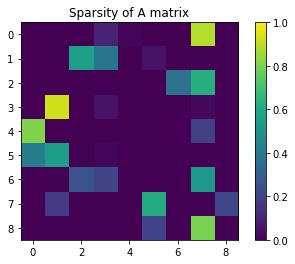

In [116]:
plt.imshow(reversed_line_HMM.A, vmax=1.0)
plt.colorbar()
plt.title('Sparsity of A matrix')
plt.show()

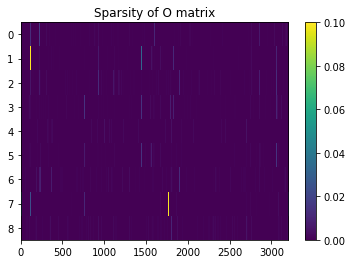

In [114]:

O_max_cols=50
O_vmax=0.1
plt.imshow(np.array(reversed_line_HMM.O)[:, :], vmax=O_vmax, aspect='auto')
plt.colorbar()
plt.title('Sparsity of O matrix')
plt.show()


In [121]:
length = len(reversed_line_HMM.O) 
max_obs = np.zeros([length,10])

for i in range(length):
    temp = np.array(reversed_line_HMM.O[i])
    max_obs[i,:] = temp.argsort()[-10:][::-1]
    
for i in range(length):
    print('Top 10 words that associate the most with state',i)
    for j in range(10):
        print(inverse_words_dict[max_obs[i,j]])#,reversed_line_HMM.O[i][int(max_obs[i,j])])

Top 10 words that associate the most with state 0
the
me
love
self
thee
so
beauty
you
and
this
Top 10 words that associate the most with state 1
and
thou
i
not
is
that
but
which
you
as
Top 10 words that associate the most with state 2
that
love
but
no
for
sweet
which
the
nor
eye
Top 10 words that associate the most with state 3
so
if
then
art
be
that
i
as
yet
dost
Top 10 words that associate the most with state 4
sight
alone
away
days
pride
day
rhyme
woe
prove
pen
Top 10 words that associate the most with state 5
to
in
of
for
with
by
i
that
shall
when
Top 10 words that associate the most with state 6
mine
me
no
thine
own
face
sweet
mind
most
tongue
Top 10 words that associate the most with state 7
my
the
thy
of
to
a
in
i
his
your
Top 10 words that associate the most with state 8
thee
heart
all
time
be
show
night
self
eye
truth


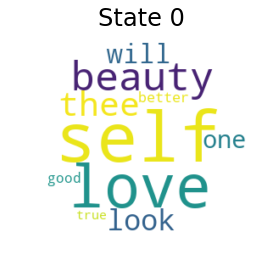

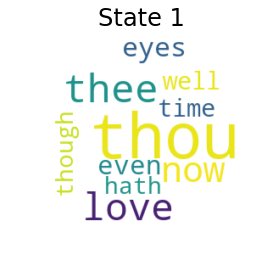

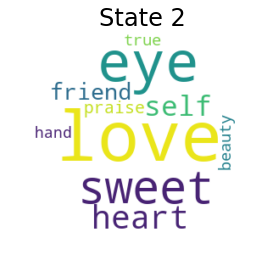

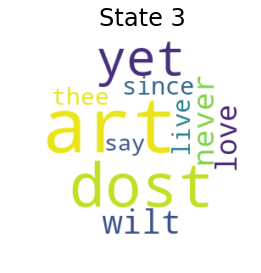

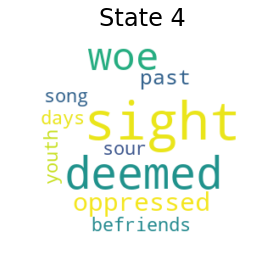

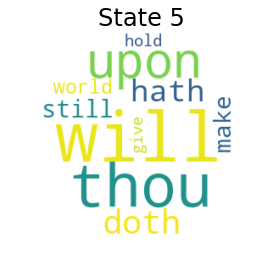

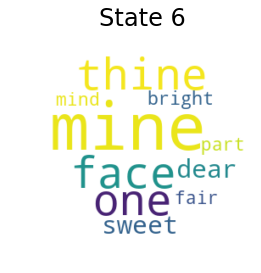

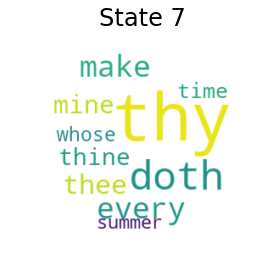

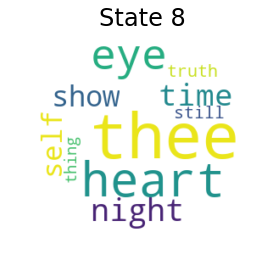

In [104]:
def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def states_to_wordclouds(hmm, obs_map, max_words=10, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds



wordclouds = states_to_wordclouds(reversed_line_HMM, words_dict)

# Poem Generation

In [262]:
# Generate the seeds using the last words HMM and then get the coupling rhymes. These will act as seeds for the 
# second HMM which generates the line backwards

# Emit 7 words from this HMM that learned the last word chains
# Take the 0th component because the 1st component shows the hidden state
last_words_emission_idx = last_word_chain_HMM.generate_emission(7)[0]
last_words_emission = [inverse_words_dict[idx] for idx in last_words_emission_idx]
print(" ".join(last_words_emission))

# Use the rhyme dictionary to get the corresponding rhyme words
rhymed_words_emission = [random.choice(list(rhyme_pairs[word])) for word in last_words_emission]
rhymed_words_emission_idx = [words_dict[word] for word in rhymed_words_emission]
print(" ".join(rhymed_words_emission))


# Join all them together in the appropriate alternating fashion
last_words_seeds_idx = []
for i in range(3):
    last_words_seeds_idx.extend([last_words_emission_idx[2*i], last_words_emission_idx[2*i+1]])
    last_words_seeds_idx.extend([rhymed_words_emission_idx[2*i], rhymed_words_emission_idx[2*i+1]])
last_words_seeds_idx.extend([last_words_emission_idx[6], rhymed_words_emission_idx[6]])
last_words_seeds = [inverse_words_dict[idx] for idx in last_words_seeds_idx]
print("---")
print("\n".join(last_words_seeds))

suppose day this created cruel worth bred
those stay kiss defeated fuel forth dead
---
suppose
day
those
stay
this
created
kiss
defeated
cruel
worth
fuel
forth
bred
dead


In [263]:
# Actually make a sonnet now. Take the 14 seeds from before, construct the lines backwards, and check for syllable count.
# If it cannot fit the right syllable count, we regenerate the line.

sonnet = []
# Iterate over each of the 14 seeds for each line
for seed_idx in last_words_seeds_idx:
    exactly_10_syllables = False
    
    while not exactly_10_syllables:
        # Generate the line using the seed
        line = list(reversed_line_HMM.generate_emission(10, seed=seed_idx)[0])
        # Reverse the line
        line = line[::-1]
        # Add the seed at the back of the line and convert back to words
        line.append(seed_idx)
        line = [inverse_words_dict[word] for word in line]
        
        # Start from the back of the line and start adding syllables. Initially we have an empty set because we will initialise
        # it when we read the last word. Use sets to prevent duplicates.
        syllable_count = set([])
        # Count backward from the last word in the line until 0
        for i in range(len(line)-1, -1, -1):
            
            # Only for the last word, we also add possible end-of-line syllable counts
            # It is empty so we initialise it by adding elements 
            if i == len(line)-1:
                # First initialise all the normal syllables
                syllable_count = set(syllables_dict[line[i]])
                # Then add all the end syllables
                syllable_count.update(end_syllables_dict[line[i]])

            # For words that are not the last, we need to iterate over the new possible readings + previous possible counts
            else:
                # Since each word can have >1 possible syllables, we need to iterate over all past counts and
                # all possible syllable counts of the new word. Use sets to prevent duplicates.
                syllable_count = {count+syl for count in syllable_count for syl in syllables_dict[line[i]]}
                # If at any point we hit 10 we are done. We chop off the line starting from when we reached 10.
                if 10 in syllable_count:
                    line = line[i:]
                    exactly_10_syllables = True
                    break
    # Once we are out of that while loop, we have exactly 10 syllables        
    sonnet.append(line)

# Print the sonnet itself
for idx, line in enumerate(sonnet):
    # Upper case "I" and "O" and "I'll"
    line = [word[0].upper()+word[1:] if word in ("i", "o", "i'll") else word for word in line]
    # Upper case the 1st word of each line
    line[0] = line[0][0].upper() + line[0][1:]
    
    # Add comma to each line except the last
    if idx == len(sonnet)-1:
        line[-1] += "."
    else:
        line[-1] += ","
    print(" ".join(line))

Pleasure did thine being with prove suppose,
When thy eye of and cheek the the well day,
Better doth and as thou thou in for those,
Hence thought to of shame of your wit and stay,
Compounded return of every find this,
Tongue-tied eye was in lovers for created,
Dress my whom things best mayst be longing kiss,
Strangely despite no the still defeated,
Furrows so or love the truth on his cruel,
Me as one brought thousand fairer my worth,
Or will times but have behold my debt fuel,
Beauty the thy love time's sorrows cold forth,
Thee nor found worship thy abuses bred,
Thee none swift as me every and when dead.
